# Metadata

```
Name: Maureen O'Shea (mo2cr@virginia.edu)
Course: DS5001
Date: 06 May 2022

Title: LDA Topic Models with SciKit Learn

Description: Create LDA Topic Models for corpus and separate topic models for genres within corpus using SciKit Learn wrapped in TopicModel.  Visualize mean topics per play from the overall topic model. Visualize mean topics per play using genre topic models.  Create topic dendograms.  Create heat maps of topics within acts of plays using overall topic model and genre topic models. 

Original Code Author: R.C. Alvarado, Module 08 Lab, In this notebook we create separate topic models from genres in our corpus using SciKit Learn's library wrapped in a bespoke class, TopicModel
```

# Set Up

In [1]:
data_home = "./data"
local_lib = "./lib"
data_prefix = 'folger'

In [2]:
engine_type = 'LDA' # NMF or LDA
n_terms = 1000
n_topics = 20
max_iter = 20
doc_topic_prior = .01 # .01 # Prior of document topic distribution alpha. Defaults to 1 / n_components.
topic_word_prior = .1 # .1 # Prior of topic word distribution beta. Defaults to 1 / n_components.

In [3]:
BAG = ['play_code', 'act_num']

In [4]:
import pandas as pd
import numpy as np
import plotly_express as px
from sklearn.decomposition import LatentDirichletAllocation as LDA

# Prepare Data

We work with the count matrix.

In [5]:
BOW = pd.read_csv(f'{data_home}/{data_prefix}-BOW.csv').set_index(BAG+['term_str'])
VOCAB = pd.read_csv(f'{data_home}/{data_prefix}-VOCAB2.csv').set_index('term_str')
LIB = pd.read_csv(f'{data_home}/{data_prefix}-LIB2.csv').set_index('play_code')

In [6]:
# DOC = pd.DataFrame(index=X.index).join(LIB[['auth','title', 'genre']])
# DOC['label'] = DOC.apply(lambda x: f"{x.auth}, {x.title[:10].strip()} ({x.genre[:1]}) {x.name[0]}:{x.name[1]}", 1)

# Define a Topic Model Class

In [7]:
import pandas as pd
import numpy as np
from sklearn.decomposition import LatentDirichletAllocation as LDA, NMF

class TopicModel():            

    bow_count_col:str = 'n'
    n_topics:int = 20
    n_top_terms:int = None
    engine_type = 'LDA' # Also NMF
    n_terms = 1000
    alpha = None
    beta = None

    # LDA Params
    max_iter:int = 20
    learning_offset:float = 50.
    random_state:int = 0
    
    # NMF Params
    nmf_init = 'nndsvd'
    nmf_max_iter = 1000
    
    def __init__(self, BOW:pd.DataFrame):
        self.BOW = BOW
        
    def create_X(self):
        X = self.BOW[self.bow_count_col].unstack()
        V = X.count().to_frame('df')
        X = X.fillna(0)
        V['idf'] = np.log2(len(X)/V.df)
        V['dfidf'] = V.df * V.idf
        SIGS = V.sort_values('dfidf', ascending=False).head(self.n_terms).index
        self.X = X[SIGS]
        self.V = V              
        
    def get_model(self):
        
        if self.engine_type == 'LDA':
            self.engine = LDA(n_components=self.n_topics, 
                              max_iter=self.max_iter, 
                              learning_offset=self.learning_offset, 
                              random_state=self.random_state,
                              doc_topic_prior=self.alpha,
                              topic_word_prior=self.beta)

        elif self.engine_type == 'NMF':
            self.engine = NMF(n_components=self.n_topics, 
                              max_iter=self.nmf_max_iter,
                              init=self.nmf_init, 
                              random_state=1, 
                              alpha_W=self.alpha, 
                              alpha_H=self.beta,
                              l1_ratio=.5)
                
        self.THETA = pd.DataFrame(self.engine.fit_transform(self.X.values), index=self.X.index)
        self.THETA.columns.name = 'topic_id'
        
        self.PHI = pd.DataFrame(self.engine.components_, columns=self.X.columns)
        self.PHI.index.name = 'topic_id'
        self.PHI.columns.name = 'term_str'
        
        self.TOPIC = self.PHI.sum(1).to_frame('phi_sum')
        self.TOPIC['theta_sum'] = self.THETA.sum()

    def describe_topics(self):
        
        PHI_P = (self.PHI.T / self.PHI.T.sum())
        PHI_I = np.log2(1/PHI_P)
        self.TOPIC['h'] = round((PHI_I * PHI_P).sum().sort_values(ascending=False), 2)
        if not self.n_top_terms:
            self.n_top_terms = round(self.TOPIC.h.mean())
            
        # Compute relevant terms
        self.get_relevant_terms(0)            

        self.TOPIC['top_terms'] = self.PHI.stack().to_frame('topic_weight')\
            .groupby('topic_id')\
            .apply(lambda x: 
                x.sort_values('topic_weight', ascending =False)\
                    .head(self.n_top_terms)\
                    .reset_index()['term_str'])\
            .apply(lambda x: ' '.join(x.replace(' ', '_')), 1)
        
        # Not using top terms from above; using from get_relevant_terms()
        self.TOPIC['label'] = self.TOPIC.apply(lambda x: f"{x.name}: {x.top_terms_rel}", 1)
                
    def get_relevant_terms(self, 𝜆 = .5):
        """
        Compute relevance of topic terms as defined by Sievert and Shirley 2014.
        C. Sievert and K. Shirley, “LDAvis: A Method for Visualizing and Interpreting Topics,” 
        in Proceedings of the workshop on interactive language learning, visualization, and interfaces, 2014, pp. 63–70.
        """
        Ptw = self.PHI.apply(lambda x: x / x.sum(), 1) # L1 norm of PHI rows, i.e. p(w|t)
        Pw = self.PHI.sum() / self.PHI.sum().sum() # Marginal probs of terms in PHI, i.e. p(w)
        self.REL = 𝜆 * np.log2(Ptw) + (1-𝜆) * np.log2(Ptw / Pw)
        self.TOPIC['top_terms_rel'] = self.REL.apply(lambda x: ' '.join(x.sort_values(ascending=False).head(self.n_top_terms).index), 1)

    def get_model_stats(self):
        # p = self.TOPIC.theta_sum / self.TOPIC.theta_sum.sum()
        self.entropy = self.TOPIC.h.sum()
        self.redundancy = 1 - self.entropy / np.log2(self.n_topics)
    
    def get_doc_stats(self):
        self.DOC = (self.THETA.T * np.log2(1/self.THETA.T)).sum().to_frame('entropy')
        self.DOC['max_topic'] = self.THETA.idxmax(1)
        
    def plot_topics(self):
        self.TOPIC.sort_values('theta_sum', ascending=True).plot.barh(y='theta_sum', x='label', figsize=(5, self.n_topics/2))

In [8]:
LIB

,play_title,year,source_file_path,genre,play_id,play_len,n_acts,n_scenes,n_speeches,label
play_code,,,,,,,,,,
AWW,All's Well That Ends Well,1602,https://www.folgerdigitaltexts.org/AWW,comedy,0,11552,5,22,419,1602 (c): All's Well That Ends Well
Ant,Antony and Cleopatra,1606,https://www.folgerdigitaltexts.org/Ant,tragedy,1,12677,5,40,721,1606 (t): Antony and Cleopatra
AYL,As You Like It,1599,https://www.folgerdigitaltexts.org/AYL,comedy,2,8058,5,16,232,1599 (c): As You Like It
Err,The Comedy of Errors,1589,https://www.folgerdigitaltexts.org/Err,comedy,3,12097,5,11,495,1589 (c): The Comedy of Errors
Cor,Coriolanus,1607,https://www.folgerdigitaltexts.org/Cor,tragedy,4,20666,5,28,812,1607 (t): Coriolanus
Cym,Cymbeline,1609,https://www.folgerdigitaltexts.org/Cym,romance,5,22281,5,24,686,1609 (r): Cymbeline
Ham,Hamlet,1600,https://www.folgerdigitaltexts.org/Ham,tragedy,6,21048,5,20,674,1600 (t): Hamlet
1H4,"Henry IV, Part 1",1597,https://www.folgerdigitaltexts.org/1H4,history,7,16214,5,22,384,"1597 (h): Henry IV, Part 1"
2H4,"Henry IV, Part 2",1597,https://www.folgerdigitaltexts.org/2H4,history,8,8652,5,21,297,"1597 (h): Henry IV, Part 2"


## Create separate indexes

In [9]:
IDX = LIB.index    # overall corpus
HIS_IDX = LIB[LIB.genre == 'history'].index    # history corpus
TRA_IDX = LIB[LIB.genre == 'tragedy'].index    # tragedy corpus
COM_IDX = LIB[LIB.genre == 'comedy'].index     # comedy corpus
ROM_IDX = LIB[LIB.genre == 'romance'].index    # romance corpus

## Overall

In [10]:
tm = TopicModel(BOW.loc[IDX])
tm.n_topics = n_topics
tm.engine_type = engine_type
tm.alpha = topic_word_prior
tm.beta = doc_topic_prior
tm.create_X()
tm.get_model()
tm.describe_topics()
tm.get_model_stats()
tm.get_doc_stats()

In [11]:
tm.DOC = BOW.loc[IDX].groupby(['play_code','act_num']).n.sum().to_frame().join(LIB[['year','play_title','genre']])
tm.DOC['label'] = tm.DOC.apply(lambda x: f"{x.year} ({x.genre[:1]}): {x.play_title}", 1)

In [12]:
tm.DOC.head()

n  year        play_title    genre  \
play_code act_num                                            
1H4       1        1213.0  1597  Henry IV, Part 1  history   
          2         823.0  1597  Henry IV, Part 1  history   
          3        1442.0  1597  Henry IV, Part 1  history   
          4        2021.0  1597  Henry IV, Part 1  history   
          5        1160.0  1597  Henry IV, Part 1  history   

                                        label  
play_code act_num                              
1H4       1        1597 (h): Henry IV, Part 1  
          2        1597 (h): Henry IV, Part 1  
          3        1597 (h): Henry IV, Part 1  
          4        1597 (h): Henry IV, Part 1  
          5        1597 (h): Henry IV, Part 1

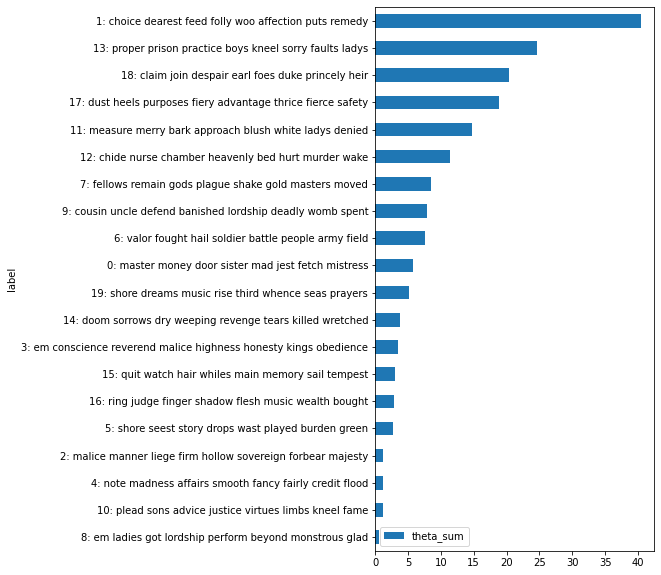

In [14]:
tm.plot_topics()

## History Genre

In [15]:
tm_his = TopicModel(BOW.loc[HIS_IDX])
tm_his.n_topics = n_topics
tm_his.engine_type = engine_type
tm_his.alpha = topic_word_prior
tm_his.beta = doc_topic_prior
tm_his.create_X()
tm_his.get_model()
tm_his.describe_topics()
tm_his.get_model_stats()
tm_his.get_doc_stats()

In [16]:
tm_his.DOC = BOW.loc[HIS_IDX].groupby(['play_code','act_num']).n.sum().to_frame().join(LIB[['year','play_title','genre']])
tm_his.DOC['label'] = tm_his.DOC.apply(lambda x: f"{x.year} ({x.genre[:1]}): {x.play_title}", 1)

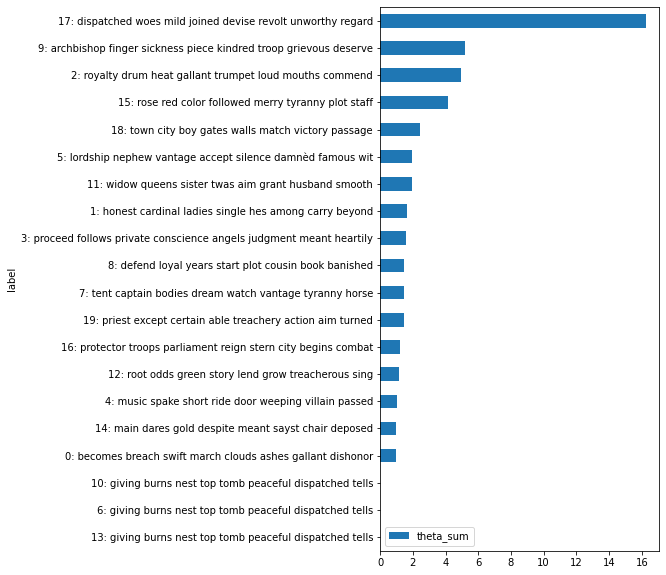

In [17]:
tm_his.plot_topics()

## Tragedy Genre

In [18]:
tm_tra = TopicModel(BOW.loc[TRA_IDX])
tm_tra.n_topics = n_topics
tm_tra.engine_type = engine_type
tm_tra.alpha = topic_word_prior
tm_tra.beta = doc_topic_prior
tm_tra.create_X()
tm_tra.get_model()
tm_tra.describe_topics()
tm_tra.get_model_stats()
tm_tra.get_doc_stats()

In [19]:
tm_tra.DOC = BOW.loc[TRA_IDX].groupby(['play_code','act_num']).n.sum().to_frame().join(LIB[['year','play_title','genre']])
tm_tra.DOC['label'] = tm_tra.DOC.apply(lambda x: f"{x.year} ({x.genre[:1]}): {x.play_title}", 1)

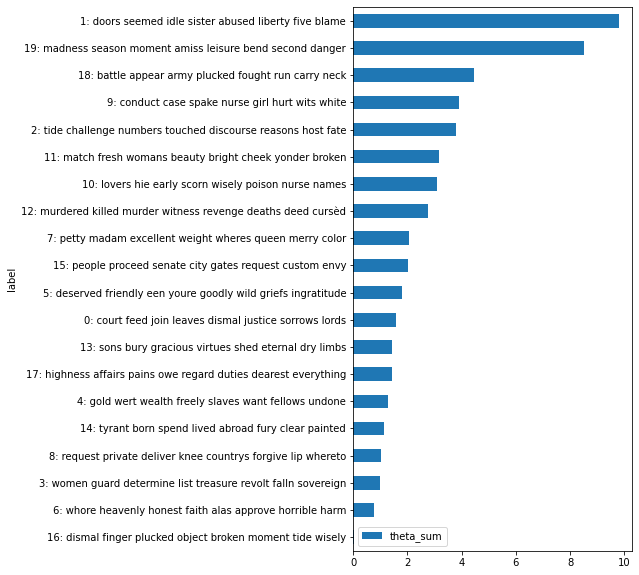

In [20]:
tm_tra.plot_topics()

## Comedy Genre

In [21]:
tm_com = TopicModel(BOW.loc[COM_IDX])
tm_com.n_topics = n_topics
tm_com.engine_type = engine_type
tm_com.alpha = topic_word_prior
tm_com.beta = doc_topic_prior
tm_com.create_X()
tm_com.get_model()
tm_com.describe_topics()
tm_com.get_model_stats()
tm_com.get_doc_stats()

In [22]:
tm_com.DOC = BOW.loc[COM_IDX].groupby(['play_code','act_num']).n.sum().to_frame().join(LIB[['year','play_title','genre']])
tm_com.DOC['label'] = tm_com.DOC.apply(lambda x: f"{x.year} ({x.genre[:1]}): {x.play_title}", 1)

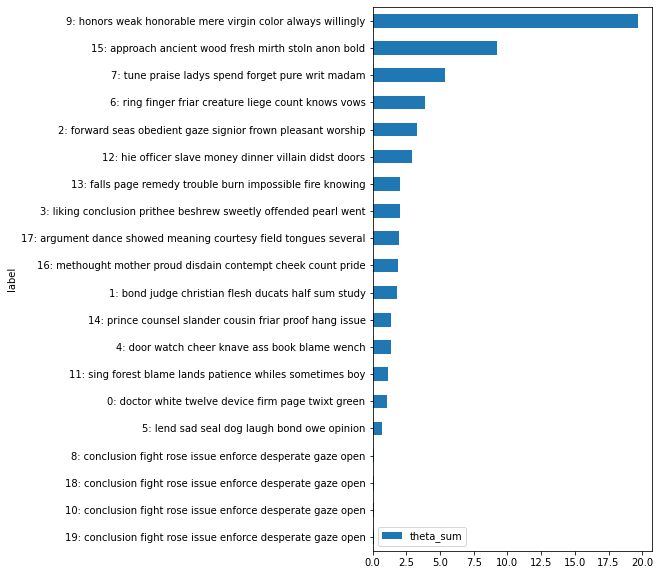

In [23]:
tm_com.plot_topics()

## Romance Genre

In [24]:
tm_rom = TopicModel(BOW.loc[ROM_IDX])
tm_rom.n_topics = n_topics
tm_rom.engine_type = engine_type
tm_rom.alpha = topic_word_prior
tm_rom.beta = doc_topic_prior
tm_rom.create_X()
tm_rom.get_model()
tm_rom.describe_topics()
tm_rom.get_model_stats()
tm_rom.get_doc_stats()

In [25]:
tm_rom.DOC = BOW.loc[ROM_IDX].groupby(['play_code','act_num']).n.sum().to_frame().join(LIB[['year','play_title','genre']])
tm_rom.DOC['label'] = tm_rom.DOC.apply(lambda x: f"{x.year} ({x.genre[:1]}): {x.play_title}", 1)

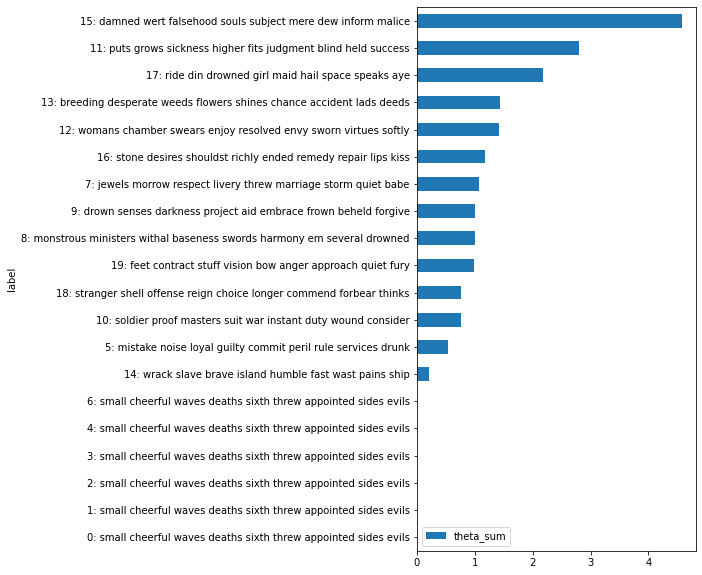

In [26]:
tm_rom.plot_topics()

# Visualize

## Heatmaps of Mean Topic per Play

In [27]:
IMG = tm.THETA.groupby('play_code').mean()
IMG.index = LIB.loc[IDX].label
IMG.columns = tm.TOPIC.label

In [28]:
IMG.T.style.background_gradient(cmap='GnBu', axis=None)

label,1602 (c): All's Well That Ends Well,1606 (t): Antony and Cleopatra,1599 (c): As You Like It,1589 (c): The Comedy of Errors,1607 (t): Coriolanus,1609 (r): Cymbeline,1600 (t): Hamlet,"1597 (h): Henry IV, Part 1","1597 (h): Henry IV, Part 2",1598 (h): Henry V,"1591 (h): Henry VI, Part 1","1590 (h): Henry VI, Part 2","1590 (h): Henry VI, Part 3",1612 (h): Henry VIII,1599 (t): Julius Caesar,1596 (h): King John,1605 (t): King Lear,1594 (c): Love's Labor's Lost,1605 (t): Macbeth,1604 (c): Measure for Measure,1596 (c): The Merchant of Venice,1600 (c): The Merry Wives of Windsor,1595 (c): A Midsummer Night's Dream,1598 (c): Much Ado About Nothing,1604 (t): Othello,1608 (r): Pericles,1595 (h): Richard II,1592 (h): Richard III,1594 (t): Romeo and Juliet,1593 (c): The Taming of the Shrew,1611 (r): The Tempest,1607 (t): Timon of Athens,1593 (t): Titus Andronicus,1601 (t): Troilus and Cressida,1599 (c): Twelfth Night,1594 (c): Two Gentlemen of Verona,1610 (r): The Winter's Tale
label,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0: master money door sister mad jest fetch mistress,0.000217,0.000091,0.000402,0.006475,0.010313,0.003941,0.011617,0.001117,0.006090,0.015568,0.016862,0.585662,0.001920,0.000144,0.006898,0.005719,0.000165,0.014061,0.027472,0.009973,0.000423,0.004787,0.004697,0.003310,0.000219,0.000134,0.000131,0.008456,0.151752,0.005650,0.032638,0.000264,0.023660,0.006885,0.007836,0.008424,0.177893
1: choice dearest feed folly woo affection puts remedy,0.117741,0.107215,0.076673,0.040976,0.020642,0.570673,0.275490,0.197528,0.178604,0.231638,0.240071,0.080848,0.107832,0.194935,0.400888,0.164536,0.038366,0.159621,0.169047,0.223323,0.316110,0.334947,0.311119,0.242989,0.326654,0.000134,0.039924,0.028265,0.550334,0.555123,0.287092,0.203473,0.068163,0.071801,0.336344,0.320588,0.487167
2: malice manner liege firm hollow sovereign forbear majesty,0.000217,0.000091,0.222042,0.000323,0.000195,0.000306,0.000517,0.001117,0.000257,0.000159,0.000145,0.000270,0.000180,0.000144,0.000175,0.000132,0.000165,0.000597,0.000165,0.000282,0.000423,0.000216,0.000211,0.000153,0.000219,0.000134,0.000131,0.000154,0.000277,0.000268,0.000601,0.000264,0.000166,0.000286,0.000186,0.000192,0.005810
3: em conscience reverend malice highness honesty kings obedience,0.000217,0.000091,0.000402,0.000323,0.000195,0.000306,0.000517,0.001117,0.024315,0.000159,0.000145,0.000270,0.000180,0.532075,0.000175,0.000132,0.000165,0.000597,0.004680,0.000282,0.000423,0.000216,0.038127,0.000153,0.000219,0.000134,0.000131,0.000154,0.000277,0.010258,0.000601,0.032367,0.000166,0.000286,0.000186,0.045522,0.005810
4: note madness affairs smooth fancy fairly credit flood,0.000217,0.000091,0.000402,0.000323,0.000195,0.000306,0.000517,0.026025,0.000257,0.000159,0.000145,0.000270,0.000180,0.000144,0.000175,0.000132,0.000165,0.000597,0.000165,0.000281,0.000423,0.000216,0.000211,0.000153,0.000219,0.000134,0.000131,0.000154,0.000277,0.000268,0.195538,0.000264,0.000166,0.000286,0.000186,0.000192,0.005810
5: shore seest story drops wast played burden green,0.000217,0.000091,0.000402,0.000323,0.000195,0.000306,0.000517,0.001117,0.000257,0.000159,0.000145,0.000270,0.000180,0.000144,0.000175,0.000132,0.000165,0.000597,0.000165,0.000282,0.066484,0.000216,0.000211,0.000153,0.000219,0.000134,0.000131,0.000154,0.000277,0.000268,0.000601,0.000264,0.000166,0.450109,0.000186,0.000192,0.005810
6: valor fought hail soldier battle people army field,0.023753,0.012134,0.050736,0.027495,0.028032,0.008001,0.000517,0.001117,0.151291,0.298367,0.069628,0.000270,0.072741,0.000144,0.000175,0.139948,0.024245,0.000597,0.055179,0.013091,0.025324,0.004894,0.240774,0.028469,0.000219,0.000134,0.012414,0.000154,0.000277,0.012399,0.004440,0.038644,0.000166,0.014298,0.141008,0.006866,0.005810
7: fellows remain gods plague shake gold masters moved,0.024208,0.000091,0.028169,0.018111,0.000195,0.000306,0.052694,0.001117,0.116715,0.271441,0.088132,0.000270,0.006747,0.000144,0.000175,0.222736,0.000165,0.000597,0.118114,0.000282,0.000423,

In [30]:
fig = px.imshow(IMG.T, color_continuous_scale='GnBu', height=700, title="SHAKESPEARE")
fig.update_layout(xaxis={'side': 'top', 'title_text':None}, yaxis={'title_text':None})

## Heatmaps of Mean Topic per play, History Genre Topic Model

In [31]:
HIS_IMG = tm_his.THETA.groupby('play_code').mean()
HIS_IMG.index = LIB.loc[HIS_IDX].label
HIS_IMG.columns = tm_his.TOPIC.label

In [32]:
HIS_IMG.T.style.background_gradient(cmap='GnBu')

label,"1597 (h): Henry IV, Part 1","1597 (h): Henry IV, Part 2",1598 (h): Henry V,"1591 (h): Henry VI, Part 1","1590 (h): Henry VI, Part 2","1590 (h): Henry VI, Part 3",1612 (h): Henry VIII,1596 (h): King John,1595 (h): Richard II,1592 (h): Richard III
label,,,,,,,,,,
0: becomes breach swift march clouds ashes gallant dishonor,0.000271,0.000503,0.196275,0.000110,0.000411,0.000258,0.000185,0.000206,0.000172,0.000163
1: honest cardinal ladies single hes among carry beyond,0.000271,0.035430,0.000218,0.012626,0.019175,0.006282,0.230002,0.025490,0.000172,0.000163
2: royalty drum heat gallant trumpet loud mouths commend,0.107133,0.198243,0.105131,0.000110,0.198391,0.115552,0.038779,0.191766,0.037367,0.000163
3: proceed follows private conscience angels judgment meant heartily,0.000271,0.000503,0.000218,0.000110,0.000411,0.000258,0.297022,0.000206,0.000172,0.023628
4: music spake short ride door weeping villain passed,0.000271,0.000503,0.000218,0.000110,0.000411,0.000258,0.000185,0.000206,0.199419,0.000163
5: lordship nephew vantage accept silence damnèd famous wit,0.198583,0.000503,0.013360,0.000110,0.000411,0.000258,0.000185,0.000206,0.002401,0.176165
6: giving burns nest top tomb peaceful dispatched tells,0.000271,0.000503,0.000218,0.000110,0.000411,0.000258,0.000185,0.000205,0.000172,0.000163
7: tent captain bodies dream watch vantage tyranny horse,0.007839,0.000503,0.054335,0.016033,0.012816,0.000258,0.000185,0.000206,0.000172,0.199520
8: defend loyal years start plot cousin book banished,0.192485,0.000503,0.000218,0.000110,0.000411,0.000258,0.000185,0.000206,0.099742,0.000163


In [33]:
fig = px.imshow(HIS_IMG.T, color_continuous_scale='GnBu', title="HISTORY", height=700)
fig.update_layout(xaxis={'side': 'top', 'title_text':None}, yaxis={'title_text':None})

## Heatmaps of Mean Topic per play, Tragedy Genre Topic Model

In [34]:
TRA_IMG = tm_tra.THETA.groupby('play_code').mean()
TRA_IMG.index = LIB.loc[TRA_IDX].label
TRA_IMG.columns = tm_tra.TOPIC.label

In [35]:
TRA_IMG.T.style.background_gradient(cmap='GnBu')

label,1606 (t): Antony and Cleopatra,1607 (t): Coriolanus,1600 (t): Hamlet,1599 (t): Julius Caesar,1605 (t): King Lear,1605 (t): Macbeth,1604 (t): Othello,1594 (t): Romeo and Juliet,1607 (t): Timon of Athens,1593 (t): Titus Andronicus,1601 (t): Troilus and Cressida
label,,,,,,,,,,,
0: court feed join leaves dismal justice sorrows lords,0.000308,0.000187,0.095612,0.000156,0.004602,0.013009,0.000184,0.000180,0.000306,0.203731,0.000215
1: doors seemed idle sister abused liberty five blame,0.116851,0.042524,0.234033,0.101641,0.622195,0.043483,0.209465,0.000180,0.511549,0.033216,0.044280
2: tide challenge numbers touched discourse reasons host fate,0.000308,0.018528,0.030286,0.157266,0.000190,0.028124,0.112983,0.000180,0.040083,0.000190,0.371876
3: women guard determine list treasure revolt falln sovereign,0.198885,0.000187,0.000197,0.000156,0.000190,0.000241,0.000184,0.000180,0.000306,0.000190,0.000215
4: gold wert wealth freely slaves want fellows undone,0.094294,0.012657,0.000197,0.018870,0.000190,0.000241,0.000184,0.000180,0.131709,0.000190,0.000215
5: deserved friendly een youre goodly wild griefs ingratitude,0.000308,0.132337,0.000197,0.000156,0.000190,0.030451,0.000184,0.000180,0.199040,0.000190,0.000215
6: whore heavenly honest faith alas approve horrible harm,0.007756,0.000187,0.000197,0.000156,0.000190,0.004729,0.118217,0.000180,0.012906,0.000190,0.008540
7: petty madam excellent weight wheres queen merry color,0.409532,0.000187,0.000197,0.000156,0.000190,0.000241,0.000184,0.000180,0.000306,0.000190,0.000215
8: request private deliver knee countrys forgive lip whereto,0.000308,0.199486,0.000197,0.000156,0.000190,0.000241,0.000184,0.000180,0.000306,0.000190,0.000215


In [36]:
fig = px.imshow(TRA_IMG.T, color_continuous_scale='GnBu', title="TRAGEDY", height=700)
fig.update_layout(xaxis={'side': 'top', 'title_text':None}, yaxis={'title_text':None})

## Heatmaps of Mean Topic per play, Comedy Genre Topic Model

In [37]:
COM_IMG = tm_com.THETA.groupby('play_code').mean()
COM_IMG.index = LIB.loc[COM_IDX].label
COM_IMG.columns = tm_com.TOPIC.label

In [38]:
COM_IMG.T.style.background_gradient(cmap='GnBu')

label,1602 (c): All's Well That Ends Well,1599 (c): As You Like It,1589 (c): The Comedy of Errors,1594 (c): Love's Labor's Lost,1604 (c): Measure for Measure,1596 (c): The Merchant of Venice,1600 (c): The Merry Wives of Windsor,1595 (c): A Midsummer Night's Dream,1598 (c): Much Ado About Nothing,1593 (c): The Taming of the Shrew,1599 (c): Twelfth Night,1594 (c): Two Gentlemen of Verona
label,,,,,,,,,,,,
0: doctor white twelve device firm page twixt green,0.000216,0.000368,0.000196,0.000416,0.000193,0.000151,0.260883,0.000295,0.000812,0.000195,0.000420,0.000191
1: bond judge christian flesh ducats half sum study,0.000216,0.002678,0.013030,0.211095,0.000193,0.112113,0.013105,0.007273,0.000812,0.000195,0.000420,0.000191
2: forward seas obedient gaze signior frown pleasant worship,0.015070,0.058079,0.036815,0.000416,0.000193,0.036167,0.013105,0.000295,0.000812,0.403253,0.011709,0.000191
3: liking conclusion prithee beshrew sweetly offended pearl went,0.000216,0.000368,0.000196,0.000416,0.000193,0.000151,0.013105,0.000295,0.195177,0.000195,0.196816,0.000191
4: door watch cheer knave ass book blame wench,0.000216,0.000368,0.199213,0.000416,0.000193,0.000151,0.013105,0.000295,0.000812,0.044342,0.000420,0.000191
5: lend sad seal dog laugh bond owe opinion,0.000216,0.000368,0.000196,0.000416,0.000193,0.132673,0.013105,0.000295,0.000812,0.000195,0.000420,0.000191
6: ring finger friar creature liege count knows vows,0.216282,0.000368,0.044265,0.000416,0.103259,0.164491,0.013105,0.000295,0.159331,0.000195,0.046998,0.033378
7: tune praise ladys spend forget pure writ madam,0.039804,0.034210,0.000196,0.267270,0.000193,0.043354,0.013105,0.000295,0.052549,0.044916,0.103808,0.462174
8: conclusion fight rose issue enforce desperate gaze open,0.000216,0.000368,0.000196,0.000416,0.000193,0.000151,0.013105,0.000295,0.000811,0.000195,0.000420,0.000191


In [39]:
fig = px.imshow(COM_IMG.T, color_continuous_scale='GnBu', title="COMEDY", height=700)
fig.update_layout(xaxis={'side': 'top', 'title_text':None}, yaxis={'title_text':None})

## Heatmaps of Mean Topic per play, Romance Genre topic Model

In [40]:
ROM_IMG = tm_rom.THETA.groupby('play_code').mean()
ROM_IMG.index = LIB.loc[ROM_IDX].label
ROM_IMG.columns = tm_rom.TOPIC.label

In [41]:
ROM_IMG.T.style.background_gradient(cmap='GnBu')

label,1609 (r): Cymbeline,1608 (r): Pericles,1611 (r): The Tempest,1610 (r): The Winter's Tale
label,,,,
0: small cheerful waves deaths sixth threw appointed sides evils,0.000168,0.000271,0.000325,0.000228
1: small cheerful waves deaths sixth threw appointed sides evils,0.000168,0.000271,0.000325,0.000228
2: small cheerful waves deaths sixth threw appointed sides evils,0.000168,0.000271,0.000325,0.000228
3: small cheerful waves deaths sixth threw appointed sides evils,0.000168,0.000271,0.000325,0.000228
4: small cheerful waves deaths sixth threw appointed sides evils,0.000168,0.000271,0.000325,0.000228
5: mistake noise loyal guilty commit peril rule services drunk,0.005831,0.000271,0.000325,0.100470
6: small cheerful waves deaths sixth threw appointed sides evils,0.000168,0.000271,0.000325,0.000228
7: jewels morrow respect livery threw marriage storm quiet babe,0.000168,0.215457,0.000325,0.000228
8: monstrous ministers withal baseness swords harmony em several drowned,0.000168,0.000271,0.199018,0.000228


In [42]:
fig = px.imshow(ROM_IMG.T, color_continuous_scale='GnBu', title="ROMANCE", height=700)
fig.update_layout(xaxis={'side': 'top', 'title_text':None}, yaxis={'title_text':None})

## Topic Dendrograms

In [43]:
import sys; sys.path.append(local_lib)

In [44]:
from hac2 import HAC

<Figure size 432x288 with 0 Axes>

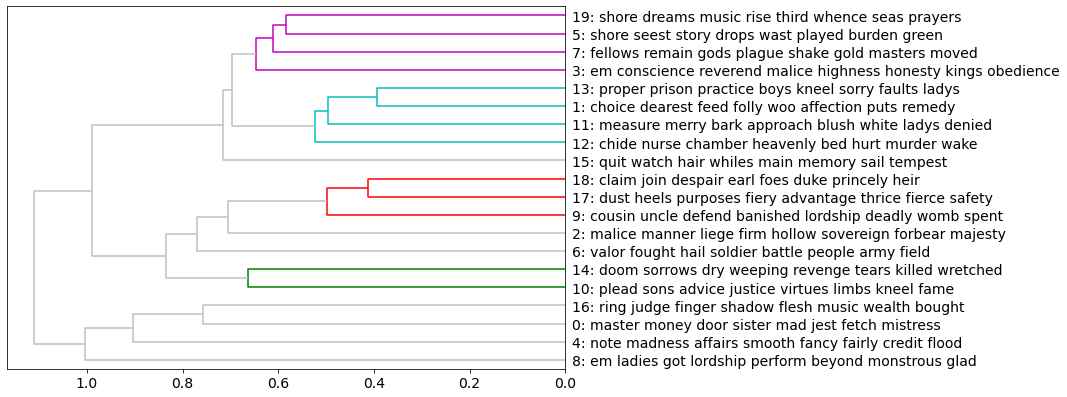

In [45]:
#OVERALL
dend_phi = HAC(tm.PHI)
dend_phi.labels = tm.TOPIC.label.to_list()
dend_phi.plot()

<Figure size 432x288 with 0 Axes>

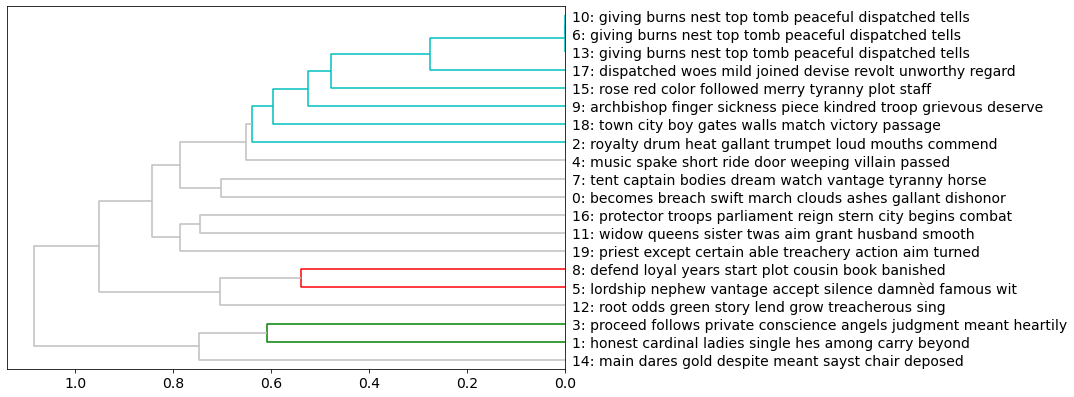

In [46]:
#HISTORY
dend_his_phi = HAC(tm_his.PHI)
dend_his_phi.labels = tm_his.TOPIC.label.to_list()
dend_his_phi.plot()

<Figure size 432x288 with 0 Axes>

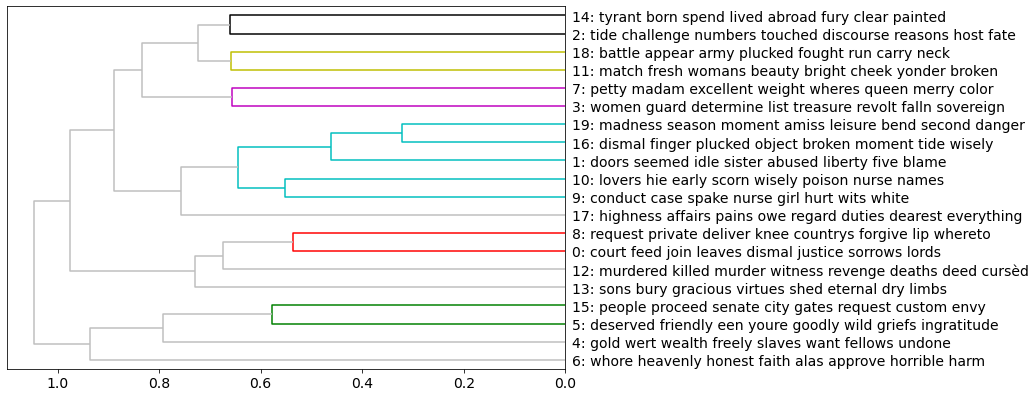

In [47]:
#TRAGEDY
dend_tra_phi = HAC(tm_tra.PHI)
dend_tra_phi.labels = tm_tra.TOPIC.label.to_list()
dend_tra_phi.plot()

<Figure size 432x288 with 0 Axes>

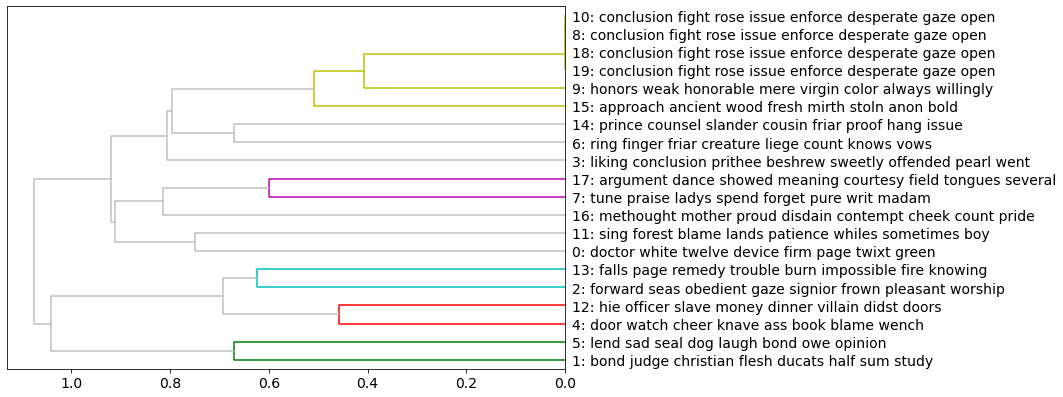

In [48]:
#COMEDY
dend_com_phi = HAC(tm_com.PHI)
dend_com_phi.labels = tm_com.TOPIC.label.to_list()
dend_com_phi.plot()

<Figure size 432x288 with 0 Axes>

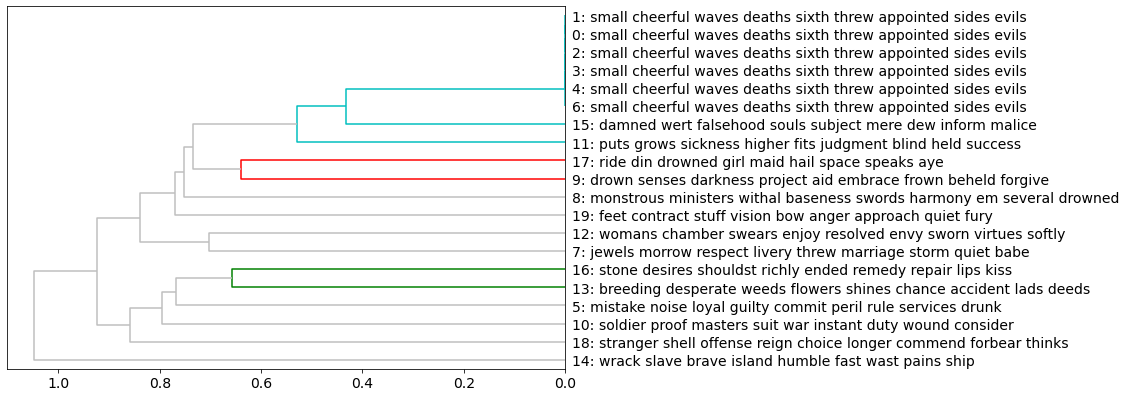

In [49]:
# ROMANCE
dend_rom_phi = HAC(tm_rom.PHI)
dend_rom_phi.labels = tm_rom.TOPIC.label.to_list()
dend_rom_phi.plot()

## Heatmaps of Topics within Plays

In [50]:
def show_book_heatmap(tm, book_id, h=None, w=None, thresh=None):
    global LIB
    
    title = LIB.loc[book_id].label

    # Pick only those topics whose mean concentration is above threshhold
    if not thresh:
        thresh = tm.THETA.loc[book_id].mean().quantile(.8)
    X = tm.THETA.loc[book_id, tm.THETA.loc[book_id].mean() >= thresh]
    if not h:
        h = int(75 * len(X.T))
    if not w:
        w = int(16 * len(X))
    if w < 1000: w = 1000
    return px.imshow(X.T, 
                     width=w, height=h, aspect='equal',
                     color_continuous_scale='GnBu', 
                     labels=dict(y='topics',x='acts'),
                     y=tm.TOPIC.loc[X.columns].label.values,
                     title=f"{title} / thresh={round(thresh, 2)}" 
    )

In [51]:
LIB.label

play_code
AWW     1602 (c): All's Well That Ends Well
Ant          1606 (t): Antony and Cleopatra
AYL                1599 (c): As You Like It
Err          1589 (c): The Comedy of Errors
Cor                    1607 (t): Coriolanus
Cym                     1609 (r): Cymbeline
Ham                        1600 (t): Hamlet
1H4              1597 (h): Henry IV, Part 1
2H4              1597 (h): Henry IV, Part 2
H5                        1598 (h): Henry V
1H6              1591 (h): Henry VI, Part 1
2H6              1590 (h): Henry VI, Part 2
3H6              1590 (h): Henry VI, Part 3
H8                     1612 (h): Henry VIII
JC                  1599 (t): Julius Caesar
Jn                      1596 (h): King John
Lr                      1605 (t): King Lear
LLL           1594 (c): Love's Labor's Lost
Mac                       1605 (t): Macbeth
MM            1604 (c): Measure for Measure
MV         1596 (c): The Merchant of Venice
Wiv    1600 (c): The Merry Wives of Windsor
MND     1595 (c): A Mi

## Heat Map of Plays in CORPUS

In [52]:
show_book_heatmap(tm, 'Tit')

In [53]:
show_book_heatmap(tm, 'Ant')

In [54]:
show_book_heatmap(tm, 'H8')

In [55]:
show_book_heatmap(tm, 'H5')

## Heat Maps of Plays within Genre

In [56]:
show_book_heatmap(tm_tra, 'Tit')

In [57]:
show_book_heatmap(tm_tra, 'Ant')

In [58]:
show_book_heatmap(tm_his, 'H8')

In [59]:
show_book_heatmap(tm_his, 'H5')

# Save

In [60]:
tm.TOPIC.to_csv(f'{data_home}/{data_prefix}-{engine_type}_TOPIC-{n_topics}.csv')
tm.THETA.to_csv(f'{data_home}/{data_prefix}-{engine_type}_THETA-{n_topics}.csv')
tm.PHI.to_csv(f'{data_home}/{data_prefix}-{engine_type}_PHI-{n_topics}.csv')

In [61]:
tm_his.TOPIC.to_csv(f'{data_home}/{data_prefix}-{engine_type}_TOPIC_HISTORY-{n_topics}.csv')
tm_his.THETA.to_csv(f'{data_home}/{data_prefix}-{engine_type}_THETA_HISTORY-{n_topics}.csv')
tm_his.PHI.to_csv(f'{data_home}/{data_prefix}-{engine_type}_PHI_HISTORY-{n_topics}.csv')

In [62]:
tm_tra.TOPIC.to_csv(f'{data_home}/{data_prefix}-{engine_type}_TOPIC_TRAGEDY-{n_topics}.csv')
tm_tra.THETA.to_csv(f'{data_home}/{data_prefix}-{engine_type}_THETA_TRAGEDY-{n_topics}.csv')
tm_tra.PHI.to_csv(f'{data_home}/{data_prefix}-{engine_type}_PHI_TRAGEDY-{n_topics}.csv')

In [63]:
tm_com.TOPIC.to_csv(f'{data_home}/{data_prefix}-{engine_type}_TOPIC_COMEDY-{n_topics}.csv')
tm_com.THETA.to_csv(f'{data_home}/{data_prefix}-{engine_type}_THETA_COMEDY-{n_topics}.csv')
tm_com.PHI.to_csv(f'{data_home}/{data_prefix}-{engine_type}_PHI_COMEDY-{n_topics}.csv')

In [64]:
tm_rom.TOPIC.to_csv(f'{data_home}/{data_prefix}-{engine_type}_TOPIC_ROMANCE-{n_topics}.csv')
tm_rom.THETA.to_csv(f'{data_home}/{data_prefix}-{engine_type}_THETA_ROMANCE-{n_topics}.csv')
tm_rom.PHI.to_csv(f'{data_home}/{data_prefix}-{engine_type}_PHI_ROMANCE-{n_topics}.csv')